In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [29]:
from analytics import (
    calculate_cagr, calculate_mdd, calculate_sharpe_ratio, 
    calculate_annualized_volatility, calculate_sortino_ratio
) 
from backtesting import (
    generate_crossover_signals, 
    backtest_strategy, 
    analyze_strategy
)

In [30]:
from data_loader import load_data
nifty = load_data("C:/Users/Lenovo/OneDrive/Desktop/Project/Market Data Analyzer/data/nifty.csv")
sp500 = load_data("C:/Users/Lenovo/OneDrive/Desktop/Project/Market Data Analyzer/data/sp500.csv")

In [31]:
strategy_df = generate_crossover_signals(nifty.copy(), 20, 50)
final_df = backtest_strategy(strategy_df)
analyze_strategy(nifty.copy(), final_df)


## 📈 Strategy vs. Buy & Hold Performance

------------------------------------------------------------------
Metric                        Strategy (SMA Crossover) Benchmark (Buy & Hold)   
------------------------------------------------------------------
Annualized Return (CAGR)      0.00                     %13.00                    %
Maximum Drawdown (MDD)        -1.00                    %-37.00                   %
Sharpe Ratio (SR)             -5.39                    0.42                     
Total Signals Generated       27                       
------------------------------------------------------------------


,Date,Close
0,2016-03-10,1.000000
1,2016-03-14,1.000000
2,2016-03-15,1.000000
3,2016-03-16,1.000000
4,2016-03-17,1.000000
...,...,...
1843,2025-11-25,1.031131
1844,2025-11-26,1.031131
1845,2025-12-01,1.031131
1846,2025-12-02,1.031131


In [32]:
def plot_equity_curves(strategy_df, benchmark_close_prices, title="Strategy vs. Benchmark Performance"):
    """
    Plots the cumulative returns (Equity Curves) of the strategy against Buy & Hold.
    """
    sns.set_style("darkgrid")
    
    # 1. Calculate Benchmark Cumulative Returns for comparison (same period)
    # Use the benchmark's closing prices from the shared time period.
    benchmark_returns = benchmark_close_prices.pct_change().fillna(0)
    benchmark_cumulative = (1 + benchmark_returns).cumprod()

    # 2. Ensure both series are aligned on the date index
    # We use the strategy's index since it starts after the 200-day warmup
    aligned_benchmark = benchmark_cumulative.loc[strategy_df.index]
    
    plt.figure(figsize=(12, 6))
    
    # Plot Strategy Equity Curve
    plt.plot(strategy_df['Cumulative_Returns'], label='Strategy (SMA Crossover)', color='green', linewidth=2)
    
    # Plot Benchmark Equity Curve
    plt.plot(aligned_benchmark, label='Benchmark (Buy & Hold)', color='blue', linestyle='--', linewidth=1.5)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Returns (Initial $1)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

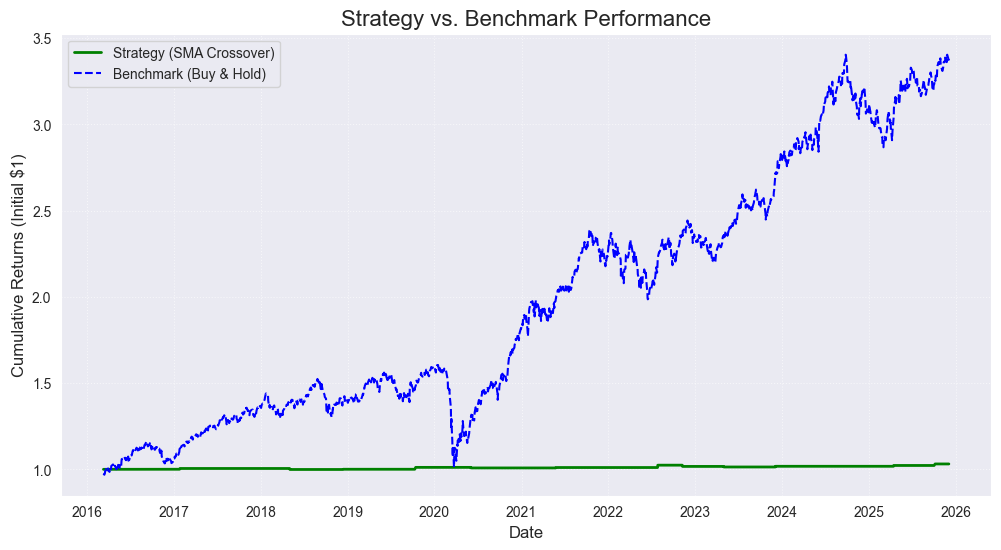

In [33]:
plot_equity_curves(final_df, nifty['Close'])

In [34]:
def plot_drawdown(strategy_df, title="Strategy Drawdown Over Time"):
    """
    Plots the Maximum Drawdown (MDD) of the strategy's equity curve.
    """
    
    # 1. Calculate Drawdown for the Strategy's Equity Curve
    equity_curve = strategy_df['Cumulative_Returns']
    peak = equity_curve.expanding().max()
    drawdown = (equity_curve / peak) - 1
    
    plt.figure(figsize=(12, 6))
    
    # Plot the Drawdown
    # We use fill_between to visually highlight the area below zero
    drawdown.plot(kind='area', color='red', alpha=0.4, label='Drawdown (%)')
    
    # Highlight the zero line
    plt.axhline(0, color='gray', linestyle='-')
    
    # Annotate the Maximum Drawdown point
    max_mdd_value = drawdown.min()
    min_date = drawdown.idxmin()
    plt.plot(min_date, max_mdd_value, 'o', color='black', markersize=8)
    plt.annotate(
        f'Max DD: {max_mdd_value:.2%}', 
        (min_date, max_mdd_value), 
        textcoords="offset points", 
        xytext=(0,-20), 
        ha='center', 
        fontsize=10
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Drawdown Percentage", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

#

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4916\408355177.py:23: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(min_date, max_mdd_value, 'o', color='black', markersize=8)


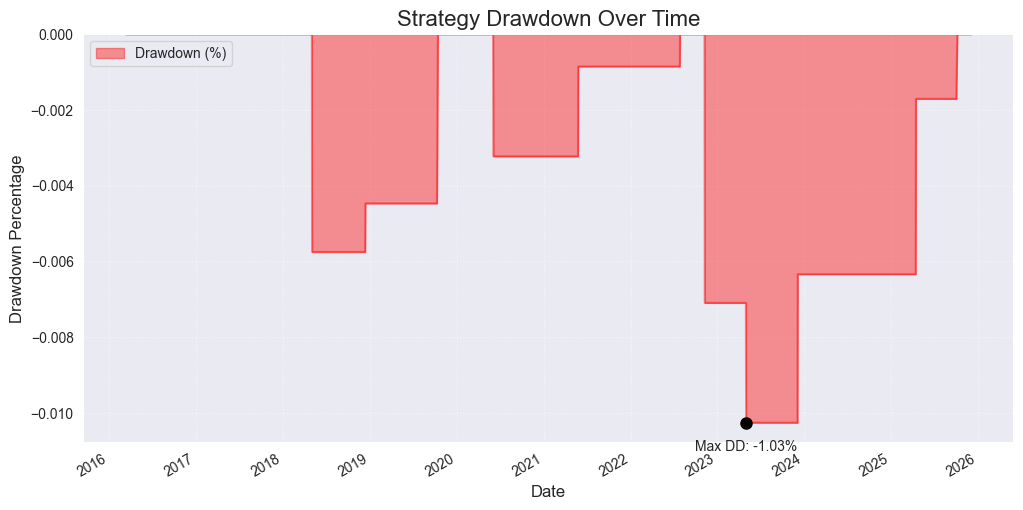

In [35]:
plot_drawdown(final_df)

In [36]:
def plot_normalized_comparison(df1, df2, label1, label2, title):
    """
    Plots the normalized price movement of two assets for comparison.
    Normalization starts both assets at the same point (index 1).
    """
    sns.set_style("whitegrid")
    
    # Ensure dataframes are aligned by index (date)
    # This is crucial if they cover slightly different periods
    df_combined = pd.concat([df1['Close'], df2['Close']], axis=1, join='inner')
    df_combined.columns = [label1, label2]
    
    # Normalize the data by dividing by the value of the first row (index 0)
    # This shows the growth relative to the starting point
    normalized_prices = df_combined / df_combined.iloc[0]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(normalized_prices.index, normalized_prices[label1], 
             label=label1, color='blue', linewidth=2)
    plt.plot(normalized_prices.index, normalized_prices[label2], 
             label=label2, color='red', linestyle='--', linewidth=1.5)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Normalized Price (Start = 1.0)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

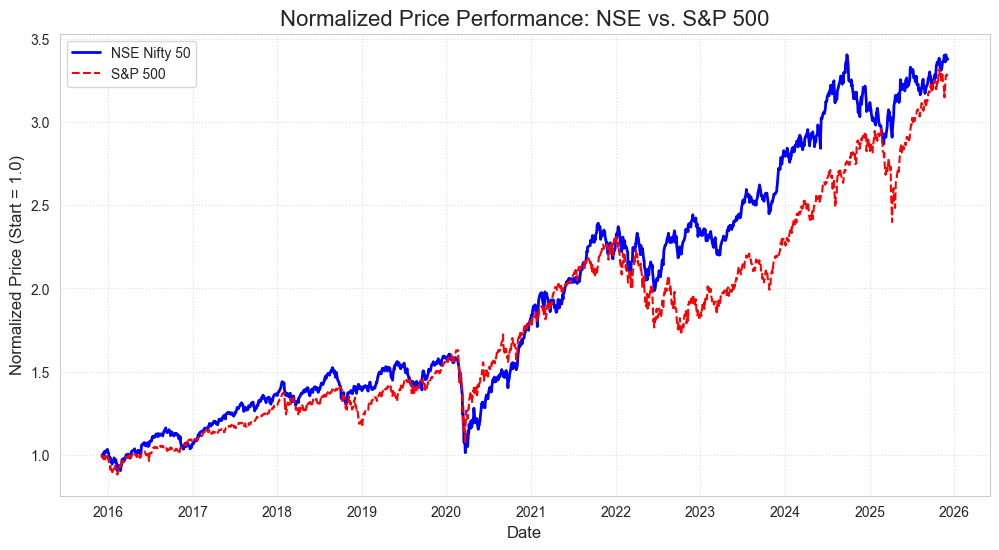

In [38]:
plot_normalized_comparison(nifty, sp500, 'NSE Nifty 50', 'S&P 500', 'Normalized Price Performance: NSE vs. S&P 500')

In [39]:
import matplotlib.dates as mdates

def plot_price_with_smas(df, asset_label, fast_window=50, slow_window=200):
    """
    Calculates and plots the Close price with Fast and Slow SMAs.
    """
    sns.set_style("darkgrid")
    df_plot = df.copy()
    
    # Calculate SMAs (Handling missing data created by rolling window)
    df_plot[f'SMA_{fast_window}'] = df_plot['Close'].rolling(window=fast_window).mean()
    df_plot[f'SMA_{slow_window}'] = df_plot['Close'].rolling(window=slow_window).mean()
    df_plot.dropna(inplace=True) 
    
    plt.figure(figsize=(12, 6))
    
    # Plotting the Close Price
    plt.plot(df_plot.index, df_plot['Close'], label=f'{asset_label} Close Price', color='gray', alpha=0.8, linewidth=1)
    
    # Plotting the Moving Averages
    plt.plot(df_plot.index, df_plot[f'SMA_{fast_window}'], label=f'SMA {fast_window}', color='blue', linewidth=1.5)
    plt.plot(df_plot.index, df_plot[f'SMA_{slow_window}'], label=f'SMA {slow_window}', color='red', linewidth=1.5)
    
    plt.title(f'{asset_label} Price with SMA {fast_window}/{slow_window} Crossover', fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

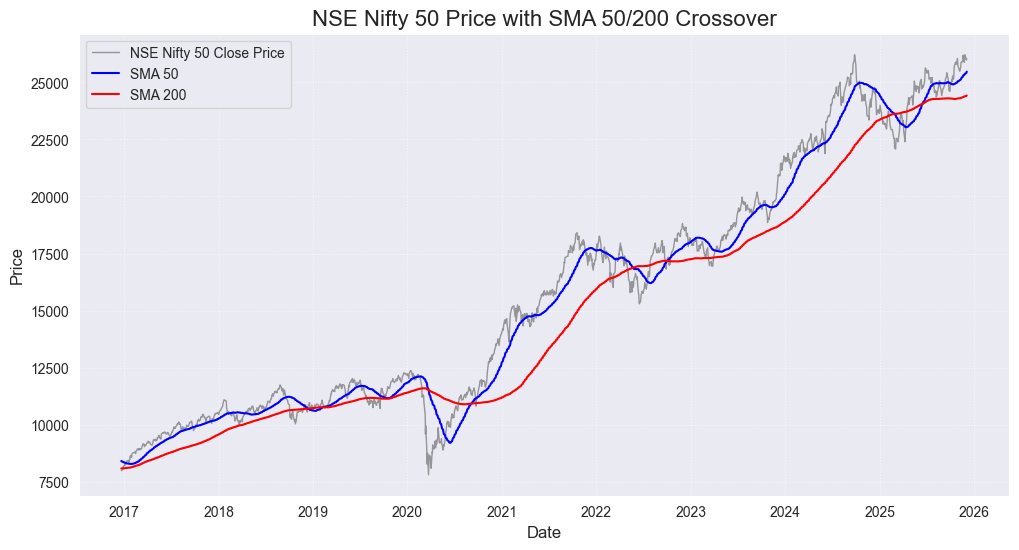

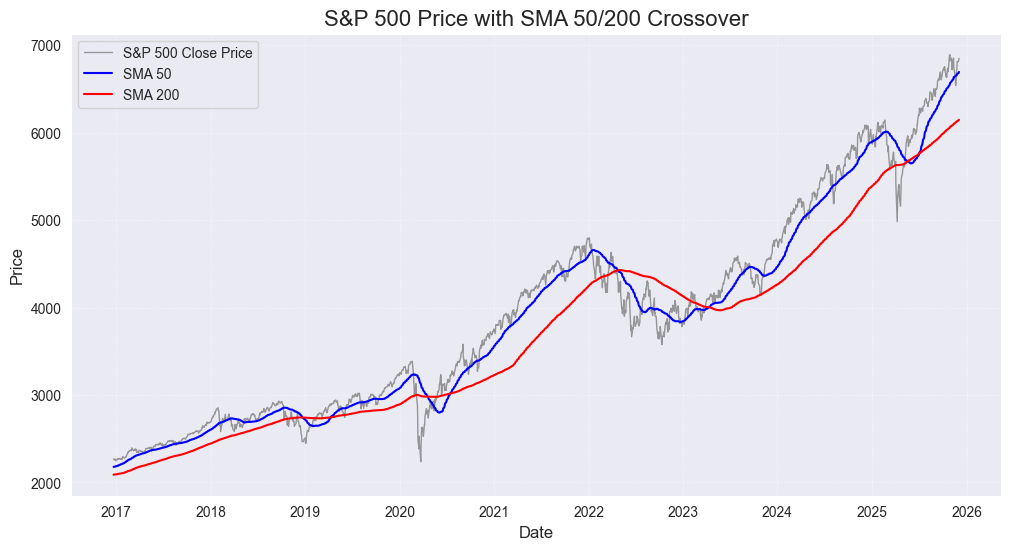

In [41]:
plot_price_with_smas(nifty, 'NSE Nifty 50')
plot_price_with_smas(sp500, 'S&P 500')

In [42]:
def plot_correlation_heatmap(df1, df2, label1, label2):
    """
    Calculates the correlation of daily returns between two assets and plots a heatmap.
    """
    # 1. Combine and Clean Data
    df_combined = pd.concat([df1['Close'], df2['Close']], axis=1, join='inner')
    df_combined.columns = [label1, label2]
    
    # 2. Calculate Daily Returns
    returns = df_combined.pct_change().dropna()
    
    # 3. Calculate the Correlation Matrix (2x2)
    correlation_matrix = returns.corr()
    
    # 4. Plot the Heatmap
    sns.set_style("white") # Use white style for clear heatmap contrast
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(
        correlation_matrix,
        annot=True,          # Display the correlation value on the map
        cmap='coolwarm',     # Color map (coolwarm is standard for correlation: blue=positive, red=negative)
        fmt=".2f",           # Format the correlation number to 2 decimal places
        linewidths=0.5,      # Lines between cells
        linecolor='black',
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    plt.title(f'Daily Return Correlation Heatmap: {label1} vs. {label2}', fontsize=16)
    plt.yticks(rotation=0)
    plt.show()

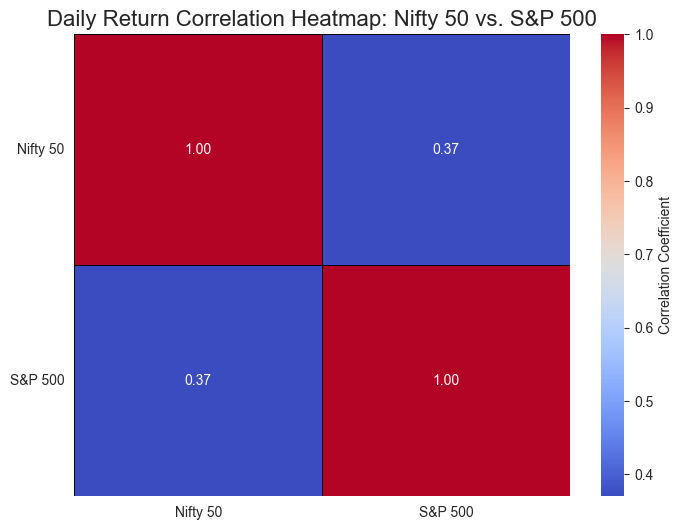

In [43]:
plot_correlation_heatmap(nifty, sp500, 'Nifty 50', 'S&P 500')